Max img_clahe: 255
Max ground truth mask (img_true): 255
| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.9071 |        0.0883 |             1 |              0.5441 |   0.2971 |


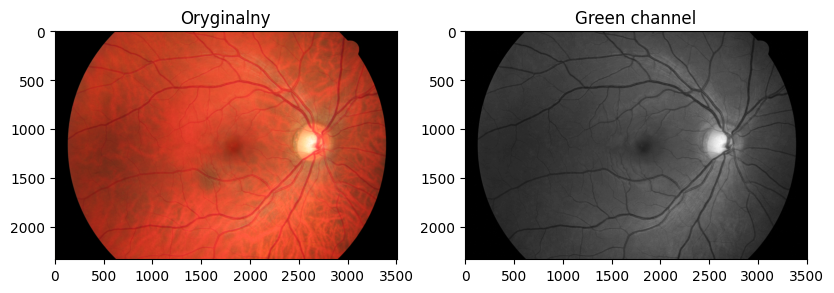

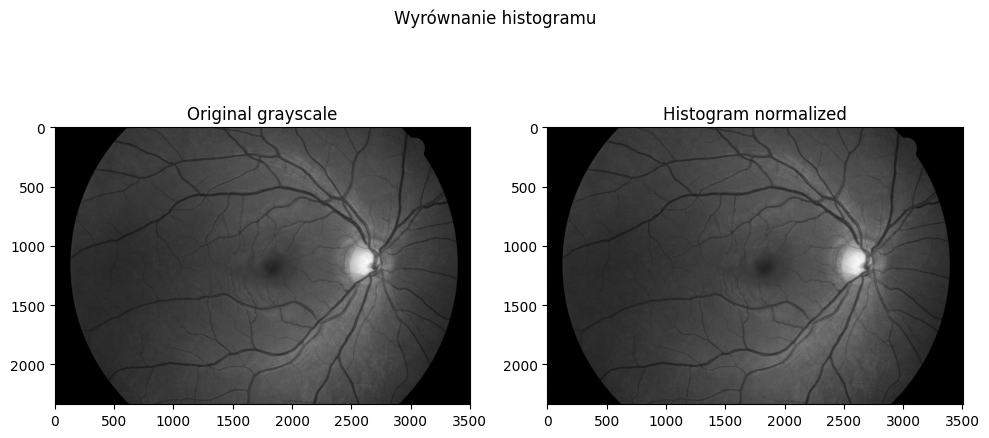

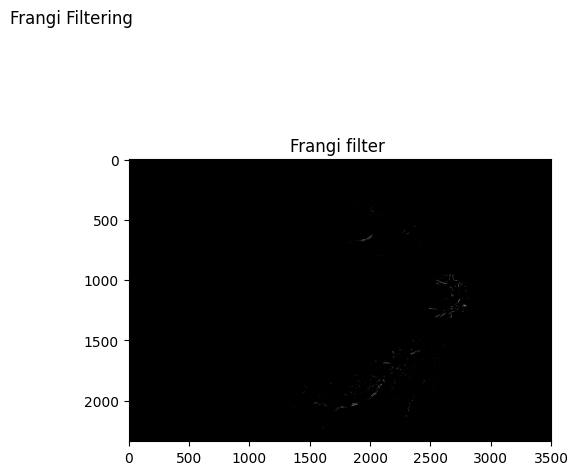

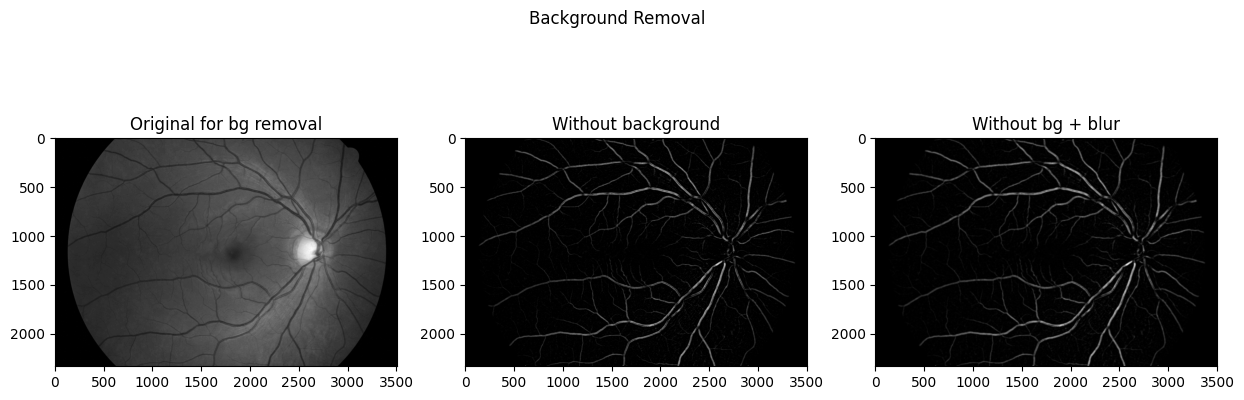

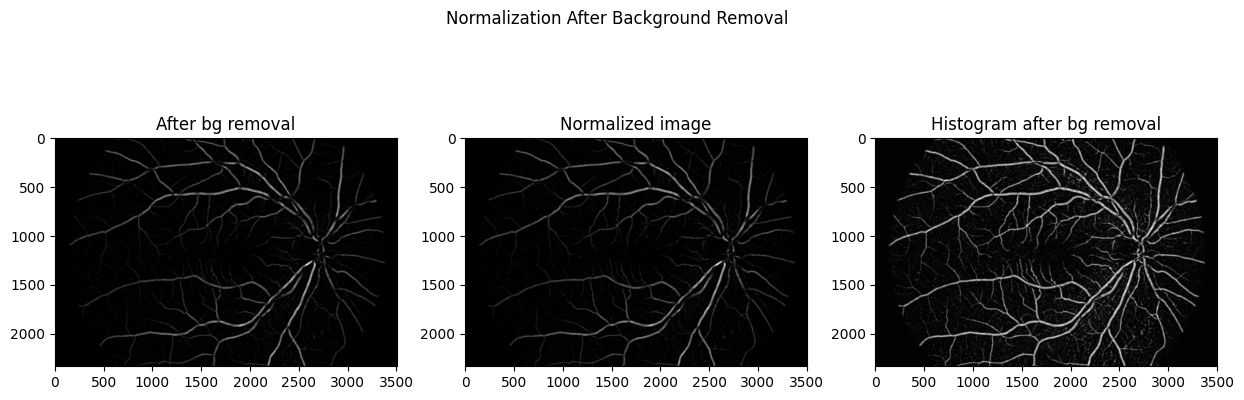

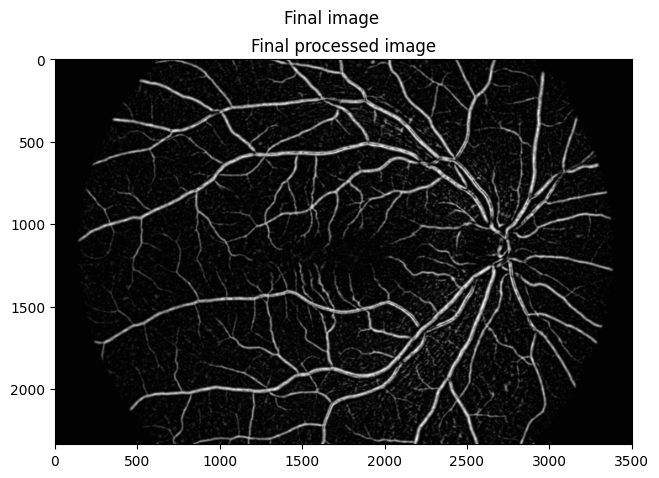

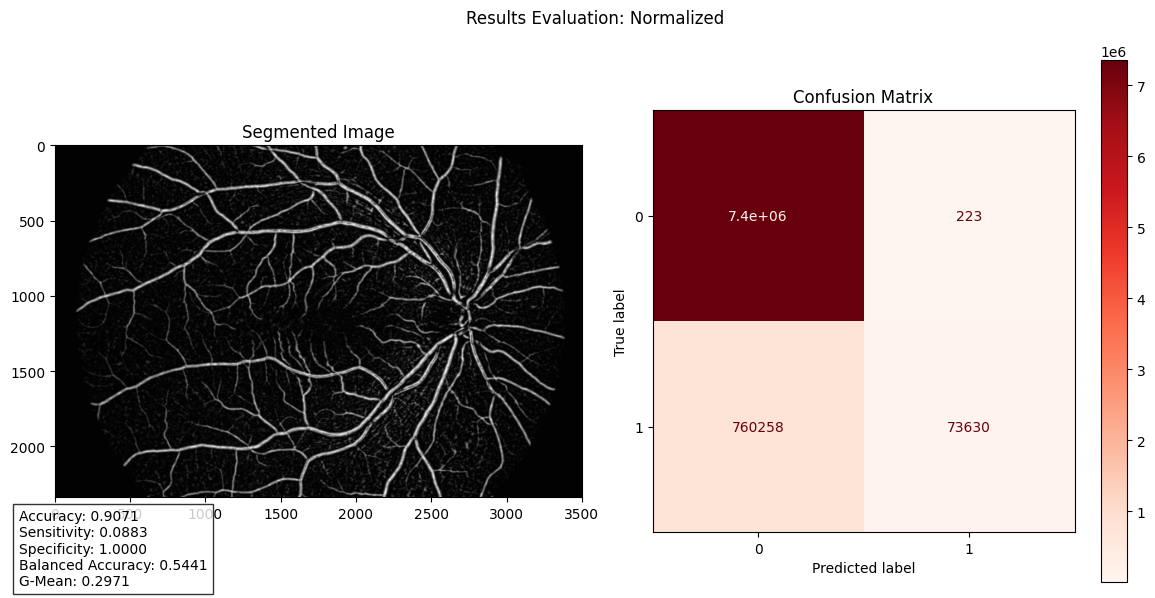

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.filters import frangi, gaussian, median, threshold_otsu
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.morphology import opening, closing, disk
from skimage.util import img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2hsv
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from tabulate import tabulate

def remove_image_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = rgb2hsv(color_img)
    v_channel = hsv[:, :, 2]

    mask = v_channel > 0.90

    # Zastosuj maskę do obrazu
    return image * mask.astype(np.uint8)

# 1. Wczytaj obraz
obraz_rgb = imread('dane/obrazy/01_h.jpg')


# Figure 1: Original image and channels
fig1 = plt.figure(figsize=(15, 8))

# Original image
axis1 = fig1.add_subplot(2, 3, 1)
axis1.set_title('Oryginalny')
axis1.imshow(obraz_rgb)

# Channel visualizations
axis2 = fig1.add_subplot(2, 3, 2)
axis2.set_title('Green channel')
axis2.imshow(obraz_rgb[:, :, 1], cmap='gray')


img_green = obraz_rgb[:, :, 1]
img_green_norm = img_green / 255.0  # equalize_adapthist działa na float64, zakres [0, 1]
img_clahe = equalize_adapthist(img_green_norm, clip_limit=0.02, nbins=256, kernel_size=(32,32))
img_clahe_uint8 = (img_clahe * 255).astype(np.uint8)

fig2 = plt.figure(figsize=(10, 5))
fig2.suptitle('Wyrównanie histogramu')

axis6 = fig2.add_subplot(1, 2, 1)
axis6.set_title('Original grayscale')
axis6.imshow(img_green, cmap='gray')

axis7 = fig2.add_subplot(1, 2, 2)
axis7.set_title('Histogram normalized')
axis7.imshow(img_green_norm, cmap='gray')

fig2.tight_layout()


# Figure 3: Frangi filter
fig3 = plt.figure(figsize=(12, 6))
fig3.suptitle('Frangi Filtering')

img_frangi = frangi(img_green_norm, sigmas=np.arange(1, 5, 0.5), black_ridges=True)
img_frangi = img_frangi / img_frangi.max()
img_frangi = np.where(img_frangi > 0.065, 1, 0)

# Apply border removal to Frangi filtered image
img_frangi_uint8 = (img_frangi * 255).astype(np.uint8)
img_frangi = remove_image_border(obraz_rgb, img_frangi_uint8)
# Convert back to binary
img_frangi = np.where(img_frangi > 0, 1, 0)


axis11 = fig3.add_subplot(1, 2, 2)
axis11.set_title('Frangi filter ')
axis11.imshow(img_frangi, cmap='gray')



# Figure 4: Morphological operations
# Konwersja obrazu do uint8 (skimage działa najlepiej w tym formacie)
img_green_uint8 = img_as_ubyte(img_green / 255.0)

# Dobór promieni (dysk o promieniu r ≈ kernel o średnicy 2r+1)
DISK_RADIUS = [2, 3, 7, 11, 13]
images = [img_green_uint8.copy()]

for radius in DISK_RADIUS:
    selem = disk(radius)
    new_img = opening(images[-1], selem)
    images.append(new_img.copy())
    new_img = closing(images[-1], selem)
    images.append(new_img.copy())

images = images[1:]  # Pomijamy pierwszy obraz (oryginalny), zostają tylko przekształcone

images = images[1:]


# Figure 5: Background removal
fig5 = plt.figure(figsize=(15, 5))
fig5.suptitle('Background Removal')

background = images[-1]
#TEJ LINIJKI NAJPEWNIEJ NIE MÓŻNA ZMIENIĆ CHYBA ŻE COŚ WYMYŚLE
img_no_background = cv2.subtract(background, img_green)
img_no_background_blur = gaussian(img_no_background, sigma=3, preserve_range=True)

axis14 = fig5.add_subplot(1, 3, 1)
axis14.set_title('Original for bg removal')
axis14.imshow(img_green, cmap='gray')

axis15 = fig5.add_subplot(1, 3, 2)
axis15.set_title('Without background')
axis15.imshow(img_no_background, cmap='gray')

axis16 = fig5.add_subplot(1, 3, 3)
axis16.set_title('Without bg + blur')
axis16.imshow(img_no_background_blur, cmap='gray')

# Figure 6: Normalization after background removal
fig6 = plt.figure(figsize=(15, 5))
fig6.suptitle('Normalization After Background Removal')


img_blur_float = img_no_background_blur / 255.0
img_clahe = equalize_adapthist(img_blur_float, clip_limit=0.02, kernel_size=(32, 32))
img_clahe = (img_clahe * 255).astype(np.uint8)

axis17 = fig6.add_subplot(1, 3, 1)
axis17.set_title('After bg removal')
axis17.imshow(img_no_background_blur, cmap='gray')

img_normalized = (img_no_background_blur / img_no_background_blur.max()) * 255
axis18 = fig6.add_subplot(1, 3, 2)
axis18.set_title('Normalized image')
axis18.imshow(img_normalized, cmap='gray')

axis19 = fig6.add_subplot(1, 3, 3)
axis19.set_title('Histogram after bg removal')
axis19.imshow(img_clahe, cmap='gray')

# Figure 7:
# Pokazanie wyników
fig8 = plt.figure(figsize=(10, 5))
fig8.suptitle('Final image')

axis21 = fig8.add_subplot(1, 1, 1)
axis21.set_title('Final processed image')
axis21.imshow(img_clahe, cmap='gray')


# === Porównanie ===
img_pred = img_clahe  # wynik segmentacji

# Wczytanie maski eksperckiej (Ground Truth)
img_true = imread('dane/naczynia/01_h.tif')

# Print maksymalnych wartości (sprawdzenie zakresów)
print("Max img_clahe:", img_pred.max())
print("Max ground truth mask (img_true):", img_true.max())

# Normalizacja wartości do zakresu [0, 1]
y_true = img_true.ravel() / img_true.max()
y_pred = img_pred.ravel() / img_pred.max()

# Konwersja do binaryzacji (naczynia: 1, tło: 0)
y_true_binary = (y_true > 0.75).astype(np.uint8)
y_pred_binary = (y_pred > 0.75).astype(np.uint8)

# Obliczenie macierzy pomyłek i metryk
cm = confusion_matrix(y_true_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true_binary, y_pred_binary)
sensitivity = recall_score(y_true_binary, y_pred_binary)
specificity = tn / (tn + fp)
balanced_accuracy = (sensitivity + specificity) / 2
g_mean = math.sqrt(sensitivity * specificity)

# Wyświetlenie metryk
headers = ["Method", "Accuracy", "Sensitivity", "Specificity", "Balanced Accuracy", "G-Mean"]
data = [["Normalized", f"{accuracy:.4f}", f"{sensitivity:.4f}", f"{specificity:.4f}",
         f"{balanced_accuracy:.4f}", f"{g_mean:.4f}"]]
print(tabulate(data, headers=headers, tablefmt="pipe"))

# Wizualizacja
fig_result = plt.figure(figsize=(12, 6))
fig_result.suptitle('Results Evaluation: Normalized')

# Obraz wynikowy
ax_img = fig_result.add_subplot(1, 2, 1)
ax_img.imshow(img_pred, cmap='gray')
ax_img.set_title("Segmented Image")

# Macierz pomyłek
ax_cm = fig_result.add_subplot(1, 2, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax_cm, cmap='Reds', colorbar=True)
ax_cm.set_title("Confusion Matrix")

# Dodanie tekstu z metrykami
metrics_text = (
    f"Accuracy: {accuracy:.4f}\n"
    f"Sensitivity: {sensitivity:.4f}\n"
    f"Specificity: {specificity:.4f}\n"
    f"Balanced Accuracy: {balanced_accuracy:.4f}\n"
    f"G-Mean: {g_mean:.4f}"
)
fig_result.text(0.02, 0.02, metrics_text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8))

fig_result.tight_layout()